In [1]:
import numpy as np
from hyppo.ksample import MMD
from sparse_shift import KCD
from scipy.stats import wilcoxon
from sparse_shift.datasets import sample_topological, sample_nonlinear_icp_sim
from sparse_shift.plotting import plot_dag
from sparse_shift.testing import test_mechanism_shifts
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Test structure

The function `test_structure` takes in observations from each setting and, given a DAG, uses KCD to assess how many conditional distributions change across the environments.

The function `get_triangle_dags` returns all DAGs on three variables.

Note that DAGs outside of the Markov equivalence class may yield unexpected numbers of changes. Given the true DAG G, 

In [531]:
def get_triangle_dags():
    """Gets all graphs on 3 variables"""
    dags = []
    for e1 in [-1, 0, 1]: #x1 - x2
        for e2 in [-1, 0, 1]: # x2 - x3
            for e3 in [-1, 0, 1]: # x3 - x1
                # skip if cyclic
                if np.abs(np.sum([e1, e2, e3])) == 3:
                    continue
                # add edges
                dag = np.asarray([[0,  0, 0], [0, 0, 0], [0, 0 ,0]])
                for i, e in enumerate([e1, e2, e3]):
                    if e == 1: # X -> Y
                        dag[i, (i+1)%3] = 1
                    elif e == -1: # X <- Y
                        dag[(i+1)%3, i] = 1
                dags.append(dag)
    return dags

In [532]:
tri_dags = get_triangle_dags()
print(len(tri_dags)) # verify equals 25

25


## 3 variable SCM

In [543]:
# X1 -> X2, X1->X3, X2->X3
true_parents = np.asarray([[0,  0, 0], [1, 0, 0], [1, 1 ,0]])
n = 100

g_noise = lambda: np.abs(np.random.standard_t(df=100))
g1_equations = [
    lambda X, U: U,
    lambda X, U: X[0] + U,
    lambda X, U: X[0] + X[1] + U,
]

g2_equations = [
    lambda X, U: U,
    lambda X, U: np.sin(2*np.pi*X[0]) + U,
    lambda X, U: X[0] + X[1] + U,
]

# 2 settings, X2|X1 changes
Xs = [
    sample_topological(n, g1_equations, g_noise, random_state=1),
    sample_topological(n, g2_equations, g_noise, random_state=2),
]

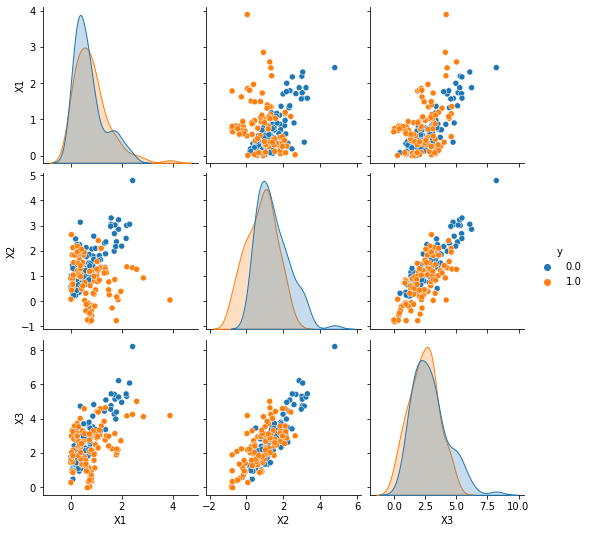

In [544]:
df = pd.DataFrame(
    np.hstack((
        np.vstack(Xs),
        np.hstack([[i]*X.shape[0] for i, X in enumerate(Xs)]).reshape(-1, 1).astype(int)
    )),
    columns=[f'X{i+1}' for i in range(Xs[0].shape[1])] + ['y']
)
sns.pairplot(df, hue='y')
plt.show()

[[[1.         0.15620629]
  [0.15620629 1.        ]]

 [[1.         0.00990099]
  [0.00990099 1.        ]]

 [[1.         0.79207921]
  [0.79207921 1.        ]]]
1


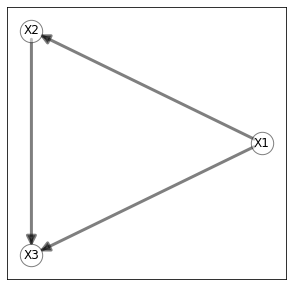

In [545]:
num_shifts, pvalues_mat = test_mechanism_shifts(Xs, true_parents, reps=100, n_jobs=-2)

print(pvalues_mat)

alpha = 0.05
print(np.sum(pvalues_mat <= alpha) // 2)

plot_dag(true_parents)

In [546]:
pval_mats = []
n_changes = []
for dag in tri_dags:
    print('.', end='')
    num_shifts, pvalues_mat = test_mechanism_shifts(Xs, dag, reps=100, n_jobs=-2)
    pval_mats.append(pvalues_mat)
    n_changes.append(np.sum(pvalues_mat <= alpha) // 2) # Number of changing mechanisms in DAG
pval_mats = np.asarray(pval_mats)
n_changes = np.asarray(n_changes)

print('Number of changes (all DAGs): ', n_changes)
print('Number of changes (MEC): ', n_changes[np.sum(tri_dags, axis=(1, 2)) == 3])

.........................Number of changes (all DAGs):  [1 1 1 1 2 1 1 2 1 1 1 1 1 2 1 1 2 2 1 1 2 1 2 2 1]
Number of changes (MEC):  [1 1 2 2 1 2]


###########################< true changes ############################
####################### minimum change, in MEC #######################


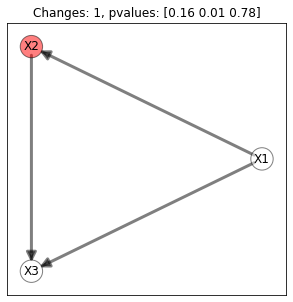

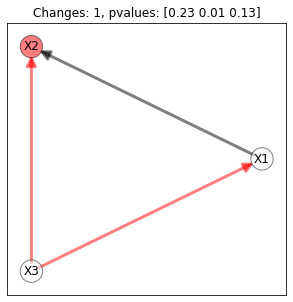

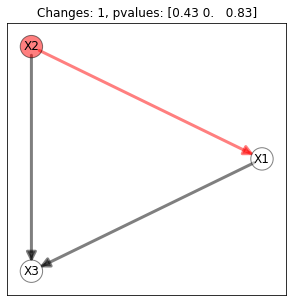

###################### > minimum change, in MEC ######################


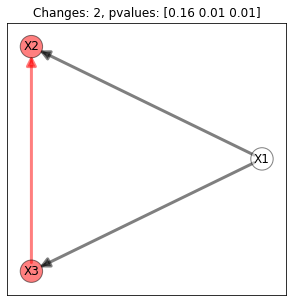

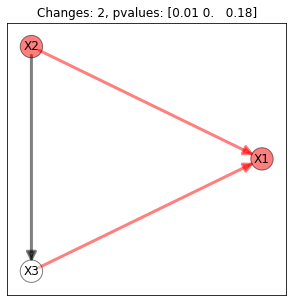

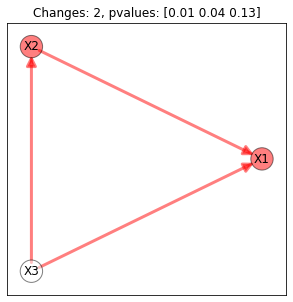

############################# not in MEC #############################


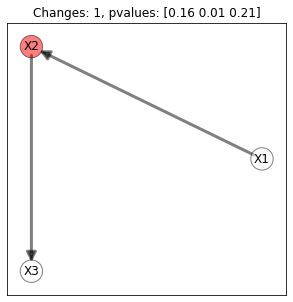

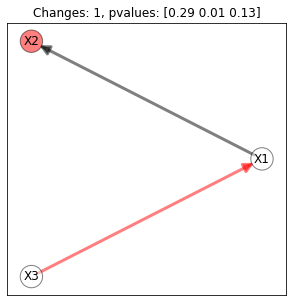

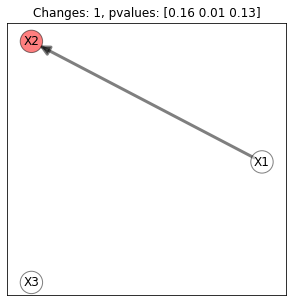

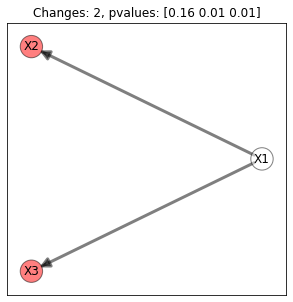

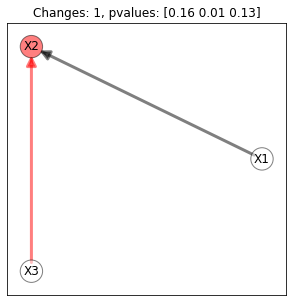

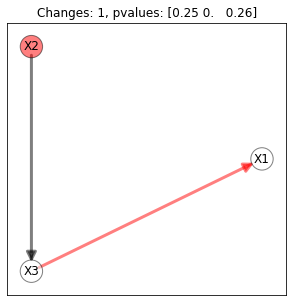

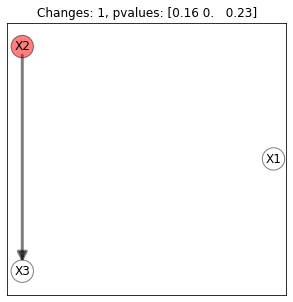

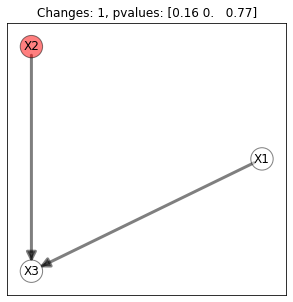

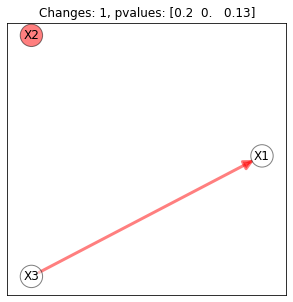

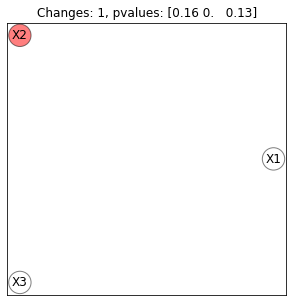

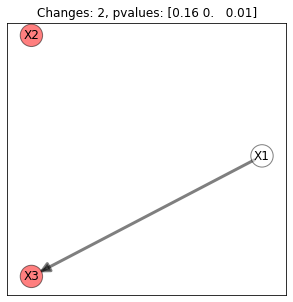

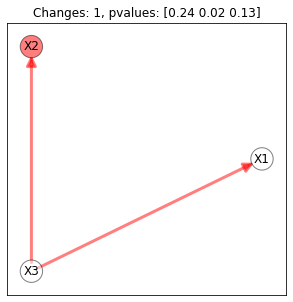

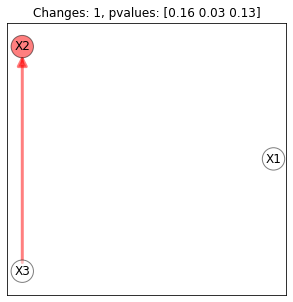

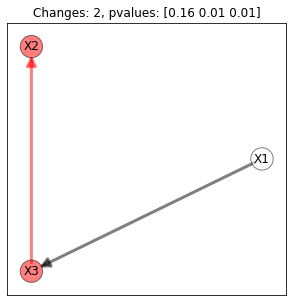

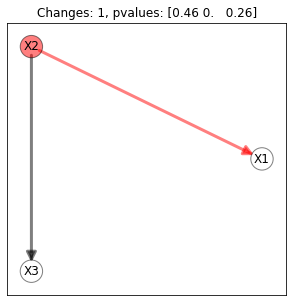

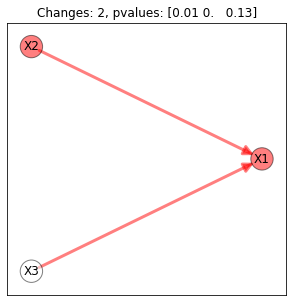

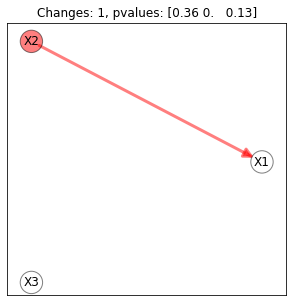

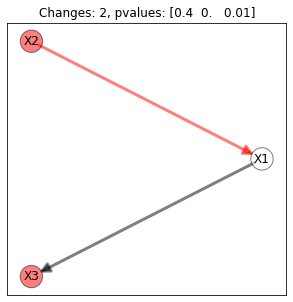

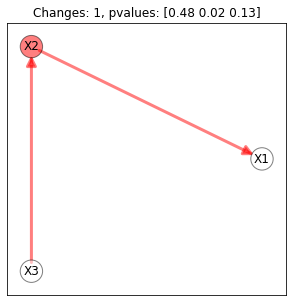

In [547]:
true_changes = n_changes[np.where((tri_dags == true_dag).all(axis=(1,2)))[0][0]]

print( '< true changes '.center(70, '#'))
for dag, nch, pvals in zip(tri_dags, n_changes, pval_mats):
    if nch < true_changes:
        plot_dag(
            dag,
            highlight_edges=dag-true_parents,
            highlight_nodes=(pvals[:, 0, 1] < alpha),
            title=f'Changes: {nch}, pvalues: {np.round(pvals, 2)[:, 0, 1]}')


print(' minimum change, in MEC '.center(70, '#'))
for dag, nch, pvals in zip(tri_dags, n_changes, pval_mats):
    if nch == true_changes and dag.sum() == 3:
        plot_dag(
            dag,
            highlight_edges=dag-true_parents,
            highlight_nodes=(pvals[:, 0, 1] < alpha),
            title=f'Changes: {nch}, pvalues: {np.round(pvals, 2)[:, 0, 1]}')

print(' > minimum change, in MEC '.center(70, '#'))
for dag, nch, pvals in zip(tri_dags, n_changes, pval_mats):
    if nch > true_changes and dag.sum() == 3:
        plot_dag(
            dag,
            highlight_edges=dag-true_parents,
            highlight_nodes=(pvals[:, 0, 1] < alpha),
            title=f'Changes: {nch}, pvalues: {np.round(pvals, 2)[:, 0, 1]}')

print(' not in MEC '.center(70, '#'))
for dag, nch, pvals in zip(tri_dags, n_changes, pval_mats):
    if dag.sum() < 3:
        plot_dag(
            dag,
            highlight_edges=dag-true_parents,
            highlight_nodes=(pvals[:, 0, 1] < alpha),
            title=f'Changes: {nch}, pvalues: {np.round(pvals, 2)[:, 0, 1]}')

## icp simulation

In [386]:
true_parents = np.asarray([[0,  0, 0], [1, 0, 0], [1, 1 ,0]])
n = 100
Xs = [
    sample_nonlinear_icp_sim(
        true_parents, n, nonlinearity='id', noise_df=10,
        intervention_targets=targets, intervention='soft',
        combination='multiplicative',# 'additive',
        intervention_shift=3,
        intervention_scale=1,
    )
    for targets in [None, 1]#1, 2]
]

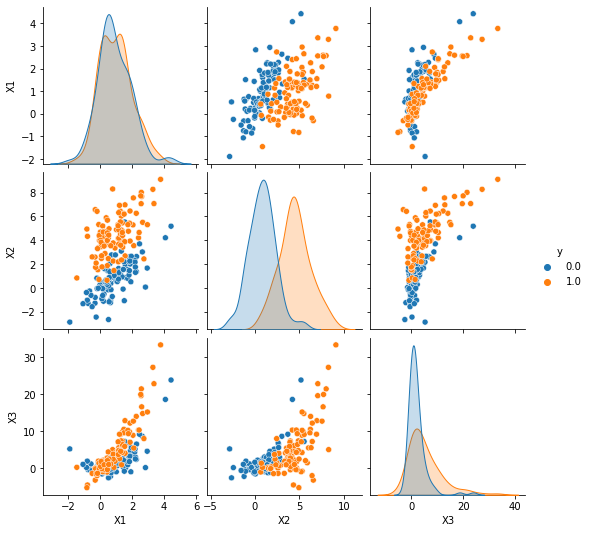

In [387]:
df = pd.DataFrame(
    np.hstack((
        np.vstack(Xs),
        np.hstack([[i]*X.shape[0] for i, X in enumerate(Xs)]).reshape(-1, 1).astype(int)
    )),
    columns=[f'X{i+1}' for i in range(Xs[0].shape[1])] + ['y']
)
sns.pairplot(df, hue='y', diag_kind='kde')
plt.show()

In [388]:
tri_dags = get_triangle_dags()
print(len(tri_dags)) # verify equals 25

25


In [389]:
num_shifts, pvalues_mat = test_mechanism_shifts(Xs, true_parents, reps=100, n_jobs=-2)

In [390]:
print(pvalues_mat)
print(np.sum(pvalues_mat <= alpha) // 2)

[[[1.         1.        ]
  [1.         1.        ]]

 [[1.         0.00990099]
  [0.00990099 1.        ]]

 [[1.         0.69306931]
  [0.69306931 1.        ]]]
1


In [391]:
tri_dags = get_triangle_dags()
print(len(tri_dags)) # verify equals 25

num_shifts, pvalues_mat = test_mechanism_shifts(Xs, true_parents, reps=100, n_jobs=-2)

print(pvalues_mat)
print(np.sum(pvalues_mat <= alpha) // 2)

pval_mats = []
n_changes = []
alpha = 0.05
for dag in tri_dags:
    print('.', end='')
    num_shifts, pvalues_mat = test_mechanism_shifts(Xs, dag, reps=100, n_jobs=-2)
    pval_mats.append(pvalues_mat)
    n_changes.append(np.sum(pvalues_mat <= alpha) // 2) # Number of changing mechanisms in DAG
pval_mats = np.asarray(pval_mats)
n_changes = np.asarray(n_changes)
print('\n')
print('Number of changes (all DAGs): ', n_changes)
print('Number of changes (MEC): ', n_changes[np.sum(tri_dags, axis=(1, 2)) == 3])

.........................

Number of changes (all DAGs):  [1 1 2 2 2 3 2 2 1 1 1 2 2 2 3 2 2 1 1 1 2 2 2 2 2]
Number of changes (MEC):  [1 3 2 1 1 2]


###########################< true changes ############################
####################### minimum change, in MEC #######################


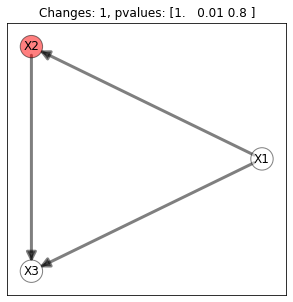

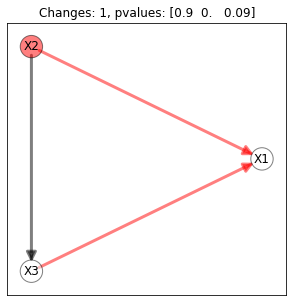

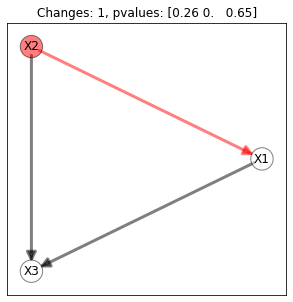

###################### > minimum change, in MEC ######################


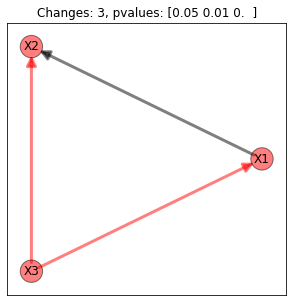

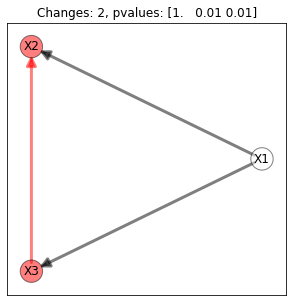

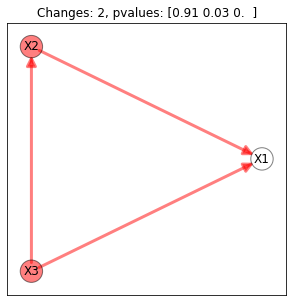

############################# not in MEC #############################


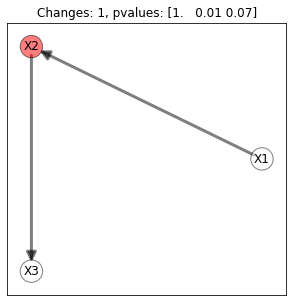

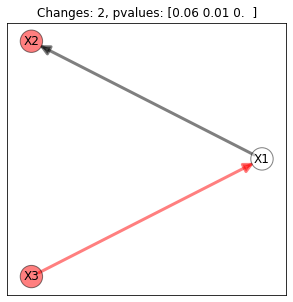

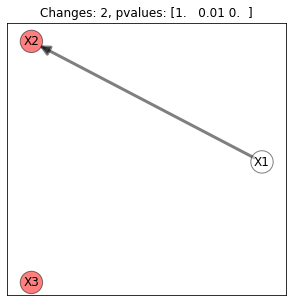

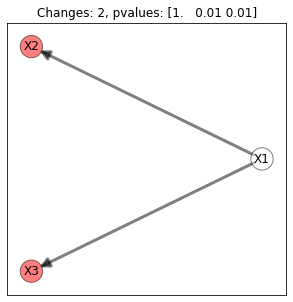

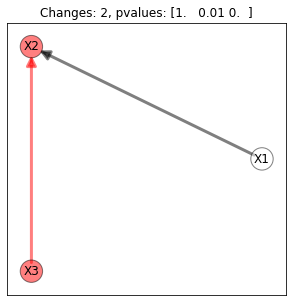

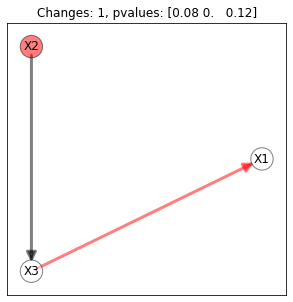

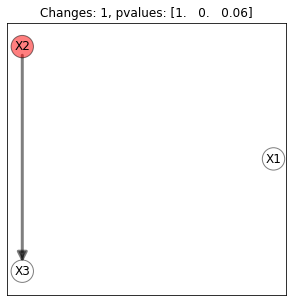

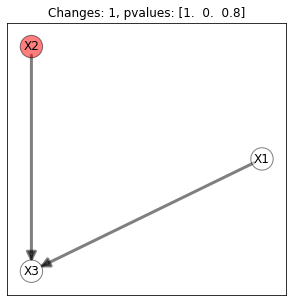

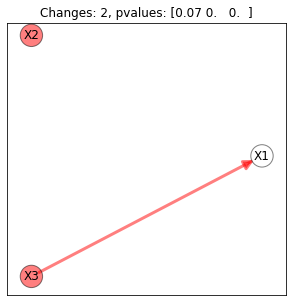

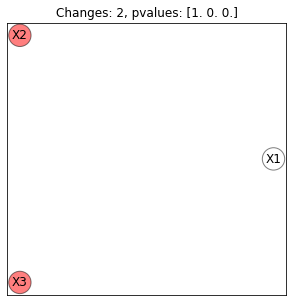

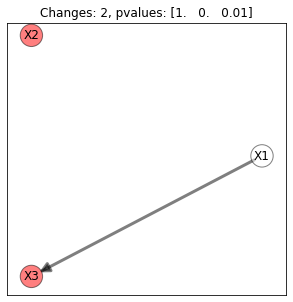

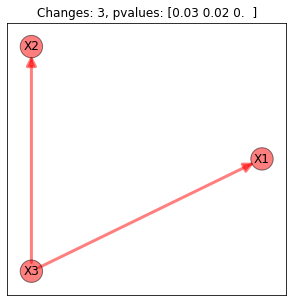

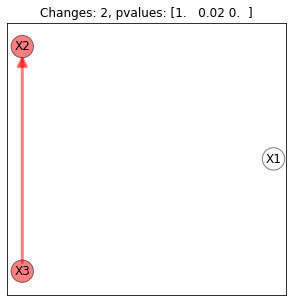

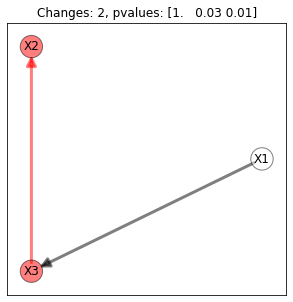

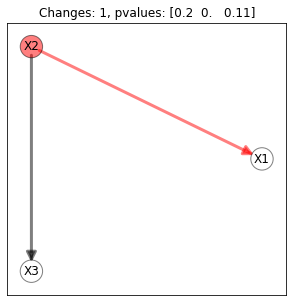

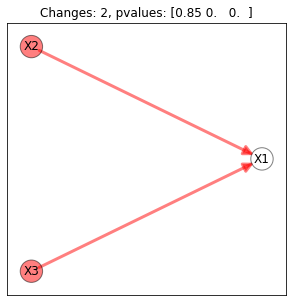

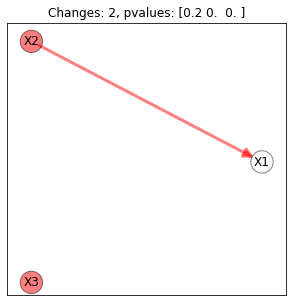

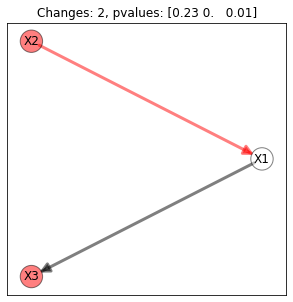

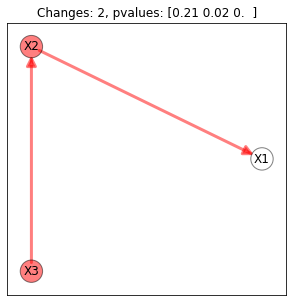

In [392]:

true_changes = n_changes[np.where((tri_dags == true_dag).all(axis=(1,2)))[0][0]]

print( '< true changes '.center(70, '#'))
idx = np.where(n_changes < true_changes)[0]
if len(idx) > 0:
    false_dag = tri_dags[idx[0]]
    plot_dag(false_dag, highlight_edges=false_dag-true_parents, highlight_nodes=(pval_mats[idx[0]][:, 0, 1] < alpha))


print(' minimum change, in MEC '.center(70, '#'))
for dag, nch, pvals in zip(tri_dags, n_changes, pval_mats):
    if nch == true_changes and dag.sum() == 3:
        plot_dag(
            dag,
            highlight_edges=dag-true_parents,
            highlight_nodes=(pvals[:, 0, 1] < alpha),
            title=f'Changes: {nch}, pvalues: {np.round(pvals, 2)[:, 0, 1]}')

print(' > minimum change, in MEC '.center(70, '#'))
for dag, nch, pvals in zip(tri_dags, n_changes, pval_mats):
    if nch > true_changes and dag.sum() == 3:
        plot_dag(
            dag,
            highlight_edges=dag-true_parents,
            highlight_nodes=(pvals[:, 0, 1] < alpha),
            title=f'Changes: {nch}, pvalues: {np.round(pvals, 2)[:, 0, 1]}')

print(' not in MEC '.center(70, '#'))
for dag, nch, pvals in zip(tri_dags, n_changes, pval_mats):
    if dag.sum() < 3:
        plot_dag(
            dag,
            highlight_edges=dag-true_parents,
            highlight_nodes=(pvals[:, 0, 1] < alpha),
            title=f'Changes: {nch}, pvalues: {np.round(pvals, 2)[:, 0, 1]}')

In [398]:
rep_nchanges = []
for rep in range(20):
    n = 100
    Xs = [
        sample_nonlinear_icp_sim(
            true_parents, n, nonlinearity='id', noise_df=10,
            intervention_targets=targets, intervention='soft',
            combination='multiplicative',# 'additive',
            intervention_shift=3,
            intervention_scale=1,
            random_state=rep
        )
        for targets in [None, 1]
    ]

    if rep == 0:
        df = pd.DataFrame(
            np.hstack((
                np.vstack(Xs),
                np.hstack([[i]*X.shape[0] for i, X in enumerate(Xs)]).reshape(-1, 1).astype(int)
            )),
            columns=[f'X{i+1}' for i in range(Xs[0].shape[1])] + ['y']
        )
        sns.pairplot(df, hue='y', diag_kind='kde')
        plt.show()
    break
    n_changes = []
    for dag in tri_dags:
        print('.', end='')
        num_shifts, pvalues_mat = test_mechanism_shifts(Xs, dag, reps=100, n_jobs=-2)
        n_changes.append(pvalues_mat[:, 0, 1]) # Number of changing mechanisms in DAG
    print('.')
    rep_nchanges.append(n_changes)

rep_nchanges = np.asarray(rep_nchanges)

..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................
..........................


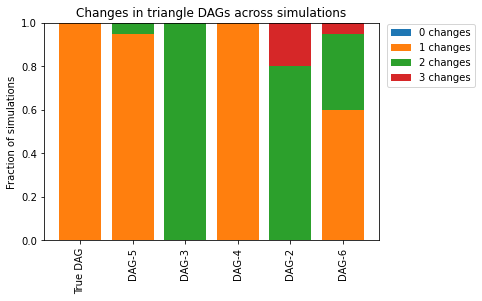

In [530]:
## Plot distribution of changes
mec_indices = np.where(np.sum(tri_dags, axis=(1, 2)) == 3)[0]
tri_dags = np.asarray(tri_dags)
alpha = 0.05 / 3
changes = np.sum(rep_nchanges < alpha, axis=-1)
sorted_dag_indices = np.argsort(np.mean(true_parents == tri_dags[mec_indices], axis=(1, 2)))[::-1]  # decreasing

ut_indices = [(0, 1), (0, 2), (1, 2)]
lt_indices = [(1, 0), (2, 0), (2, 1)]
# labels = [str([dag[c] - dag[k] for c, k in zip(ut_indices, lt_indices)]) for dag in tri_dags[mec_indices][sorted_dag_indices]]
labels = [f'DAG-{i+1}' for i in sorted_dag_indices]
labels[0] = 'True DAG'

counts = [
    np.mean(changes[:, mec_indices][:, sorted_dag_indices] == val, axis=0)
    for val in [0, 1, 2, 3]
]

fig, ax = plt.subplots()

bottom = np.zeros(counts[0].shape[0])
for i in range(len(counts)):
    ax.bar(labels, counts[i], bottom=bottom,
       label=f'{i} changes')
    bottom += counts[i]

ax.set_ylabel('Fraction of simulations')
plt.xticks(rotation=90, ha="center")
ax.set_title('Changes in triangle DAGs across simulations')
ax.legend(bbox_to_anchor=(1.01, 1.02))

plt.show()

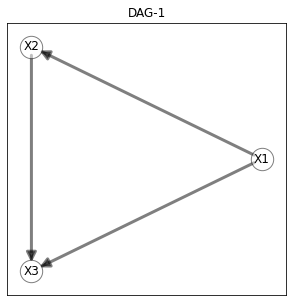

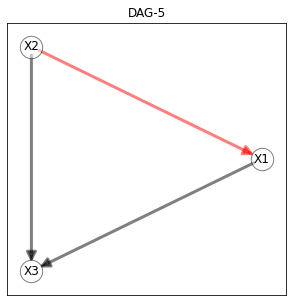

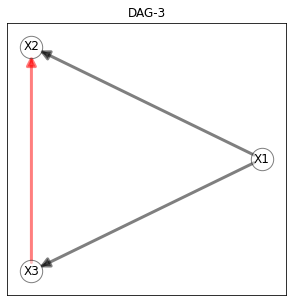

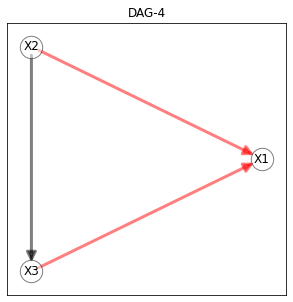

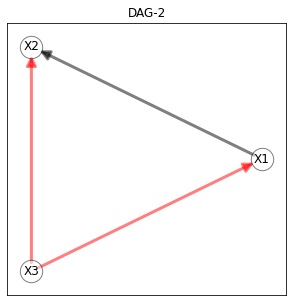

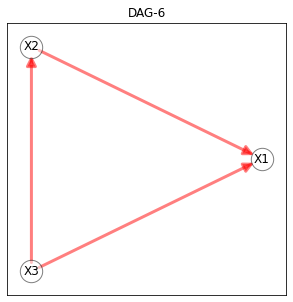

In [528]:
for i, dag in zip(sorted_dag_indices, tri_dags[mec_indices][sorted_dag_indices]):
    plot_dag(
        dag,
        highlight_edges=dag-true_parents,
        title=f'DAG-{i+1}')

In [460]:
true_idx = np.where((tri_dags == true_dag).all(axis=(1,2)))[0][0]

In [440]:
more_changes = []
fewer_changes = []
equal_changes = []
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.5, 1.0]

for alpha in alphas:
    changes = np.sum(rep_nchanges < alpha, axis=-1)
    more_changes.append(np.sum(changes > changes[:, true_idx].reshape(-1, 1), axis=1))
    equal_changes.append(np.sum(changes == changes[:, true_idx].reshape(-1, 1), axis=1) - 1)
    fewer_changes.append(np.sum(changes < changes[:, true_idx].reshape(-1, 1), axis=1))

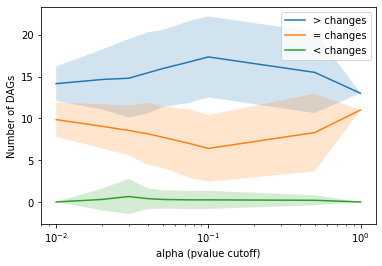

In [451]:
plt.plot(alphas, np.mean(more_changes, axis=1), label='> changes')
plt.fill_between(alphas, np.mean(more_changes, axis=1) + np.std(more_changes, axis=1), np.mean(more_changes, axis=1) - np.std(more_changes, axis=1), alpha=0.2)

plt.plot(alphas, np.mean(equal_changes, axis=1), label='= changes')
plt.fill_between(alphas, np.mean(equal_changes, axis=1) + np.std(equal_changes, axis=1), np.mean(equal_changes, axis=1) - np.std(equal_changes, axis=1), alpha=0.2)

plt.plot(alphas, np.mean(fewer_changes, axis=1), label='< changes')
plt.fill_between(alphas, np.mean(fewer_changes, axis=1) + np.std(fewer_changes, axis=1), np.mean(fewer_changes, axis=1) - np.std(fewer_changes, axis=1), alpha=0.2)

plt.ylabel('Number of DAGs')
plt.xlabel('alpha (pvalue cutoff)')
plt.legend()
plt.xscale('log')
plt.show()

## CD-NOD simulations

In [566]:
from sparse_shift.datasets.simulations import sample_cdnod_sim

In [587]:
true_parents = np.asarray([[0,  0, 0], [1, 0, 0], [1, 1 ,0]])
n = 100
Xs = [
    sample_cdnod_sim(
        true_parents, n,
        intervention_targets=targets,
        base_random_state=1,
        # domain_random_state=2,
    )
    for targets in [None, 1]#1, 2]
]

df = pd.DataFrame(
    np.hstack((
        np.vstack(Xs),
        np.hstack([[i]*X.shape[0] for i, X in enumerate(Xs)]).reshape(-1, 1).astype(int)
    )),
    columns=[f'X{i+1}' for i in range(Xs[0].shape[1])] + ['y']
)
sns.pairplot(df, hue='y', diag_kind='kde')
plt.show()

In [583]:
tri_dags = get_triangle_dags()
print(len(tri_dags)) # verify equals 25

num_shifts, pvalues_mat = test_mechanism_shifts(Xs, true_parents, reps=100, n_jobs=-2)

print(pvalues_mat)
print(np.sum(pvalues_mat <= alpha) // 2)

pval_mats = []
n_changes = []
alpha = 0.05
for dag in tri_dags:
    print('.', end='')
    num_shifts, pvalues_mat = test_mechanism_shifts(Xs, dag, reps=100, n_jobs=-2)
    pval_mats.append(pvalues_mat)
    n_changes.append(np.sum(pvalues_mat <= alpha) // 2) # Number of changing mechanisms in DAG
pval_mats = np.asarray(pval_mats)
n_changes = np.asarray(n_changes)
print('\n')
print('Number of changes (all DAGs): ', n_changes)
print('Number of changes (MEC): ', n_changes[np.sum(tri_dags, axis=(1, 2)) == 3])

25
[[[1.         0.09349682]
  [0.09349682 1.        ]]

 [[1.         0.10891089]
  [0.10891089 1.        ]]

 [[1.         0.10891089]
  [0.10891089 1.        ]]]
0
.........................

Number of changes (all DAGs):  [1 0 2 1 0 2 1 1 2 1 0 2 1 0 2 1 0 2 2 0 2 1 1 2 2]
Number of changes (MEC):  [0 2 1 2 0 2]


###########################< true changes ############################
####################### minimum change, in MEC #######################


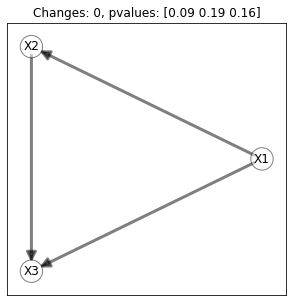

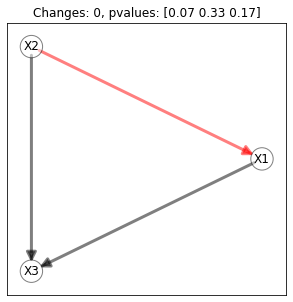

###################### > minimum change, in MEC ######################


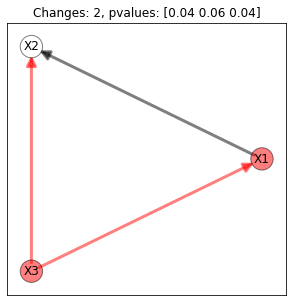

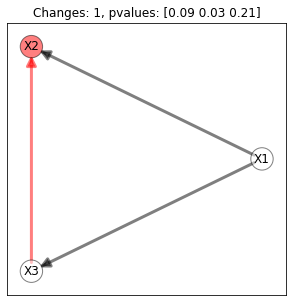

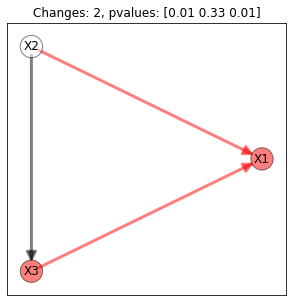

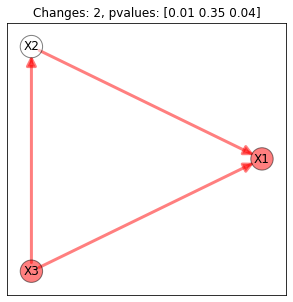

############################# not in MEC #############################


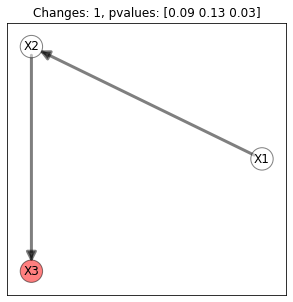

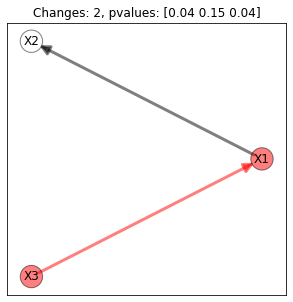

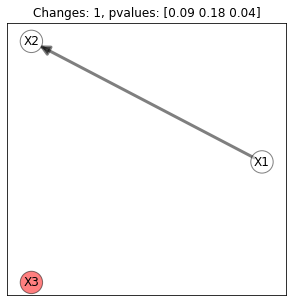

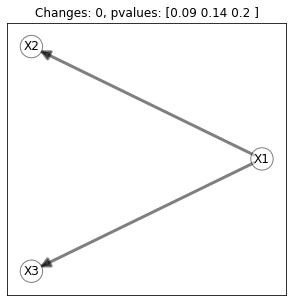

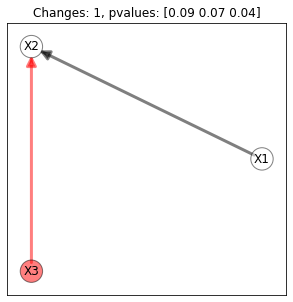

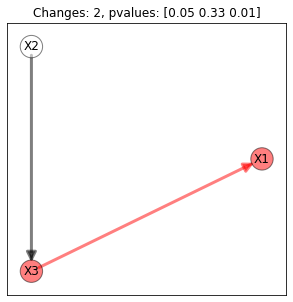

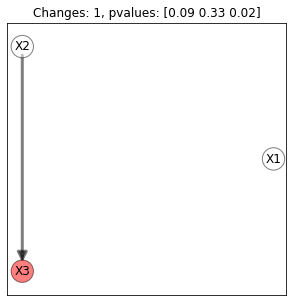

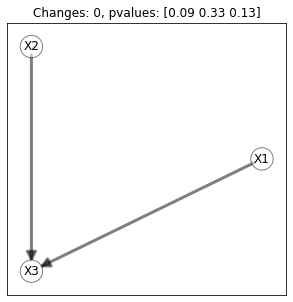

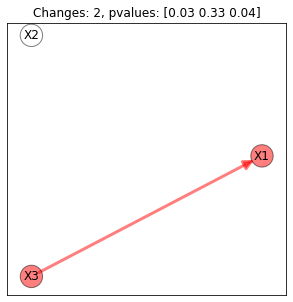

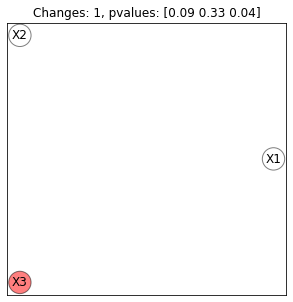

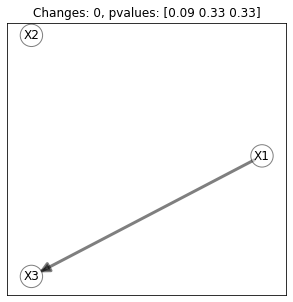

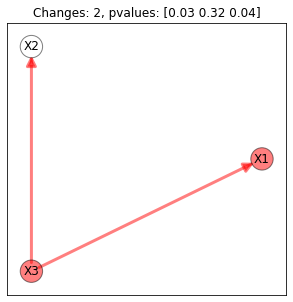

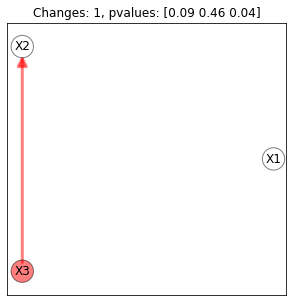

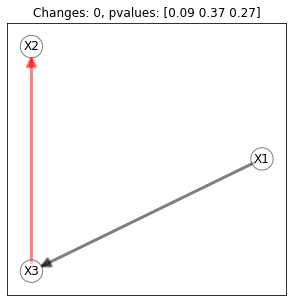

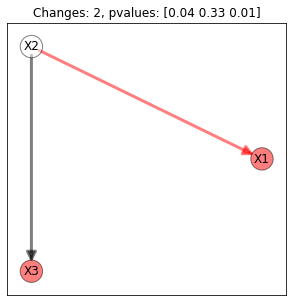

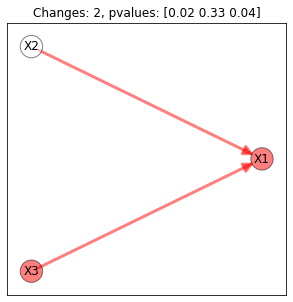

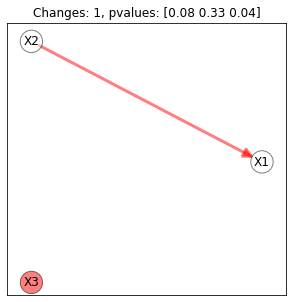

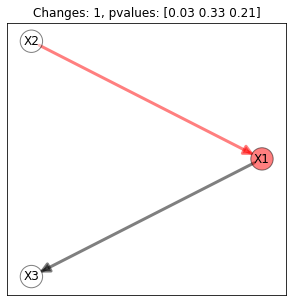

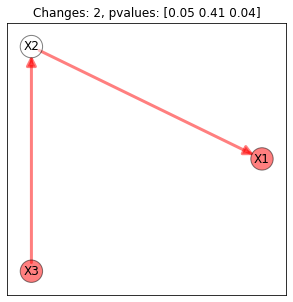

In [584]:

true_changes = n_changes[np.where((tri_dags == true_dag).all(axis=(1,2)))[0][0]]

print( '< true changes '.center(70, '#'))
idx = np.where(n_changes < true_changes)[0]
if len(idx) > 0:
    false_dag = tri_dags[idx[0]]
    plot_dag(false_dag, highlight_edges=false_dag-true_parents, highlight_nodes=(pval_mats[idx[0]][:, 0, 1] < alpha))


print(' minimum change, in MEC '.center(70, '#'))
for dag, nch, pvals in zip(tri_dags, n_changes, pval_mats):
    if nch == true_changes and dag.sum() == 3:
        plot_dag(
            dag,
            highlight_edges=dag-true_parents,
            highlight_nodes=(pvals[:, 0, 1] < alpha),
            title=f'Changes: {nch}, pvalues: {np.round(pvals, 2)[:, 0, 1]}')

print(' > minimum change, in MEC '.center(70, '#'))
for dag, nch, pvals in zip(tri_dags, n_changes, pval_mats):
    if nch > true_changes and dag.sum() == 3:
        plot_dag(
            dag,
            highlight_edges=dag-true_parents,
            highlight_nodes=(pvals[:, 0, 1] < alpha),
            title=f'Changes: {nch}, pvalues: {np.round(pvals, 2)[:, 0, 1]}')

print(' not in MEC '.center(70, '#'))
for dag, nch, pvals in zip(tri_dags, n_changes, pval_mats):
    if dag.sum() < 3:
        plot_dag(
            dag,
            highlight_edges=dag-true_parents,
            highlight_nodes=(pvals[:, 0, 1] < alpha),
            title=f'Changes: {nch}, pvalues: {np.round(pvals, 2)[:, 0, 1]}')